--- Starting Main Calculation (Analytical Sensitivity) ---
Processing Ts = 280.0 K...
Processing Ts = 281.0 K...
Processing Ts = 282.0 K...
Processing Ts = 283.0 K...
Processing Ts = 284.0 K...
Processing Ts = 285.0 K...
Processing Ts = 286.0 K...
Processing Ts = 287.0 K...
Processing Ts = 288.0 K...
Processing Ts = 289.0 K...
Processing Ts = 290.0 K...
Processing Ts = 291.0 K...
Processing Ts = 292.0 K...
Processing Ts = 293.0 K...
Processing Ts = 294.0 K...
Processing Ts = 295.0 K...
Processing Ts = 296.0 K...
Processing Ts = 297.0 K...
Processing Ts = 298.0 K...
Processing Ts = 299.0 K...
Processing Ts = 300.0 K...
Processing Ts = 301.0 K...
Processing Ts = 302.0 K...
Processing Ts = 303.0 K...
Processing Ts = 304.0 K...
Processing Ts = 305.0 K...
Processing Ts = 306.0 K...
Processing Ts = 307.0 K...
Processing Ts = 308.0 K...
Processing Ts = 309.0 K...
Processing Ts = 310.0 K...
Processing Ts = 311.0 K...
Processing Ts = 312.0 K...
Processing Ts = 313.0 K...
Processing Ts = 314.0 K

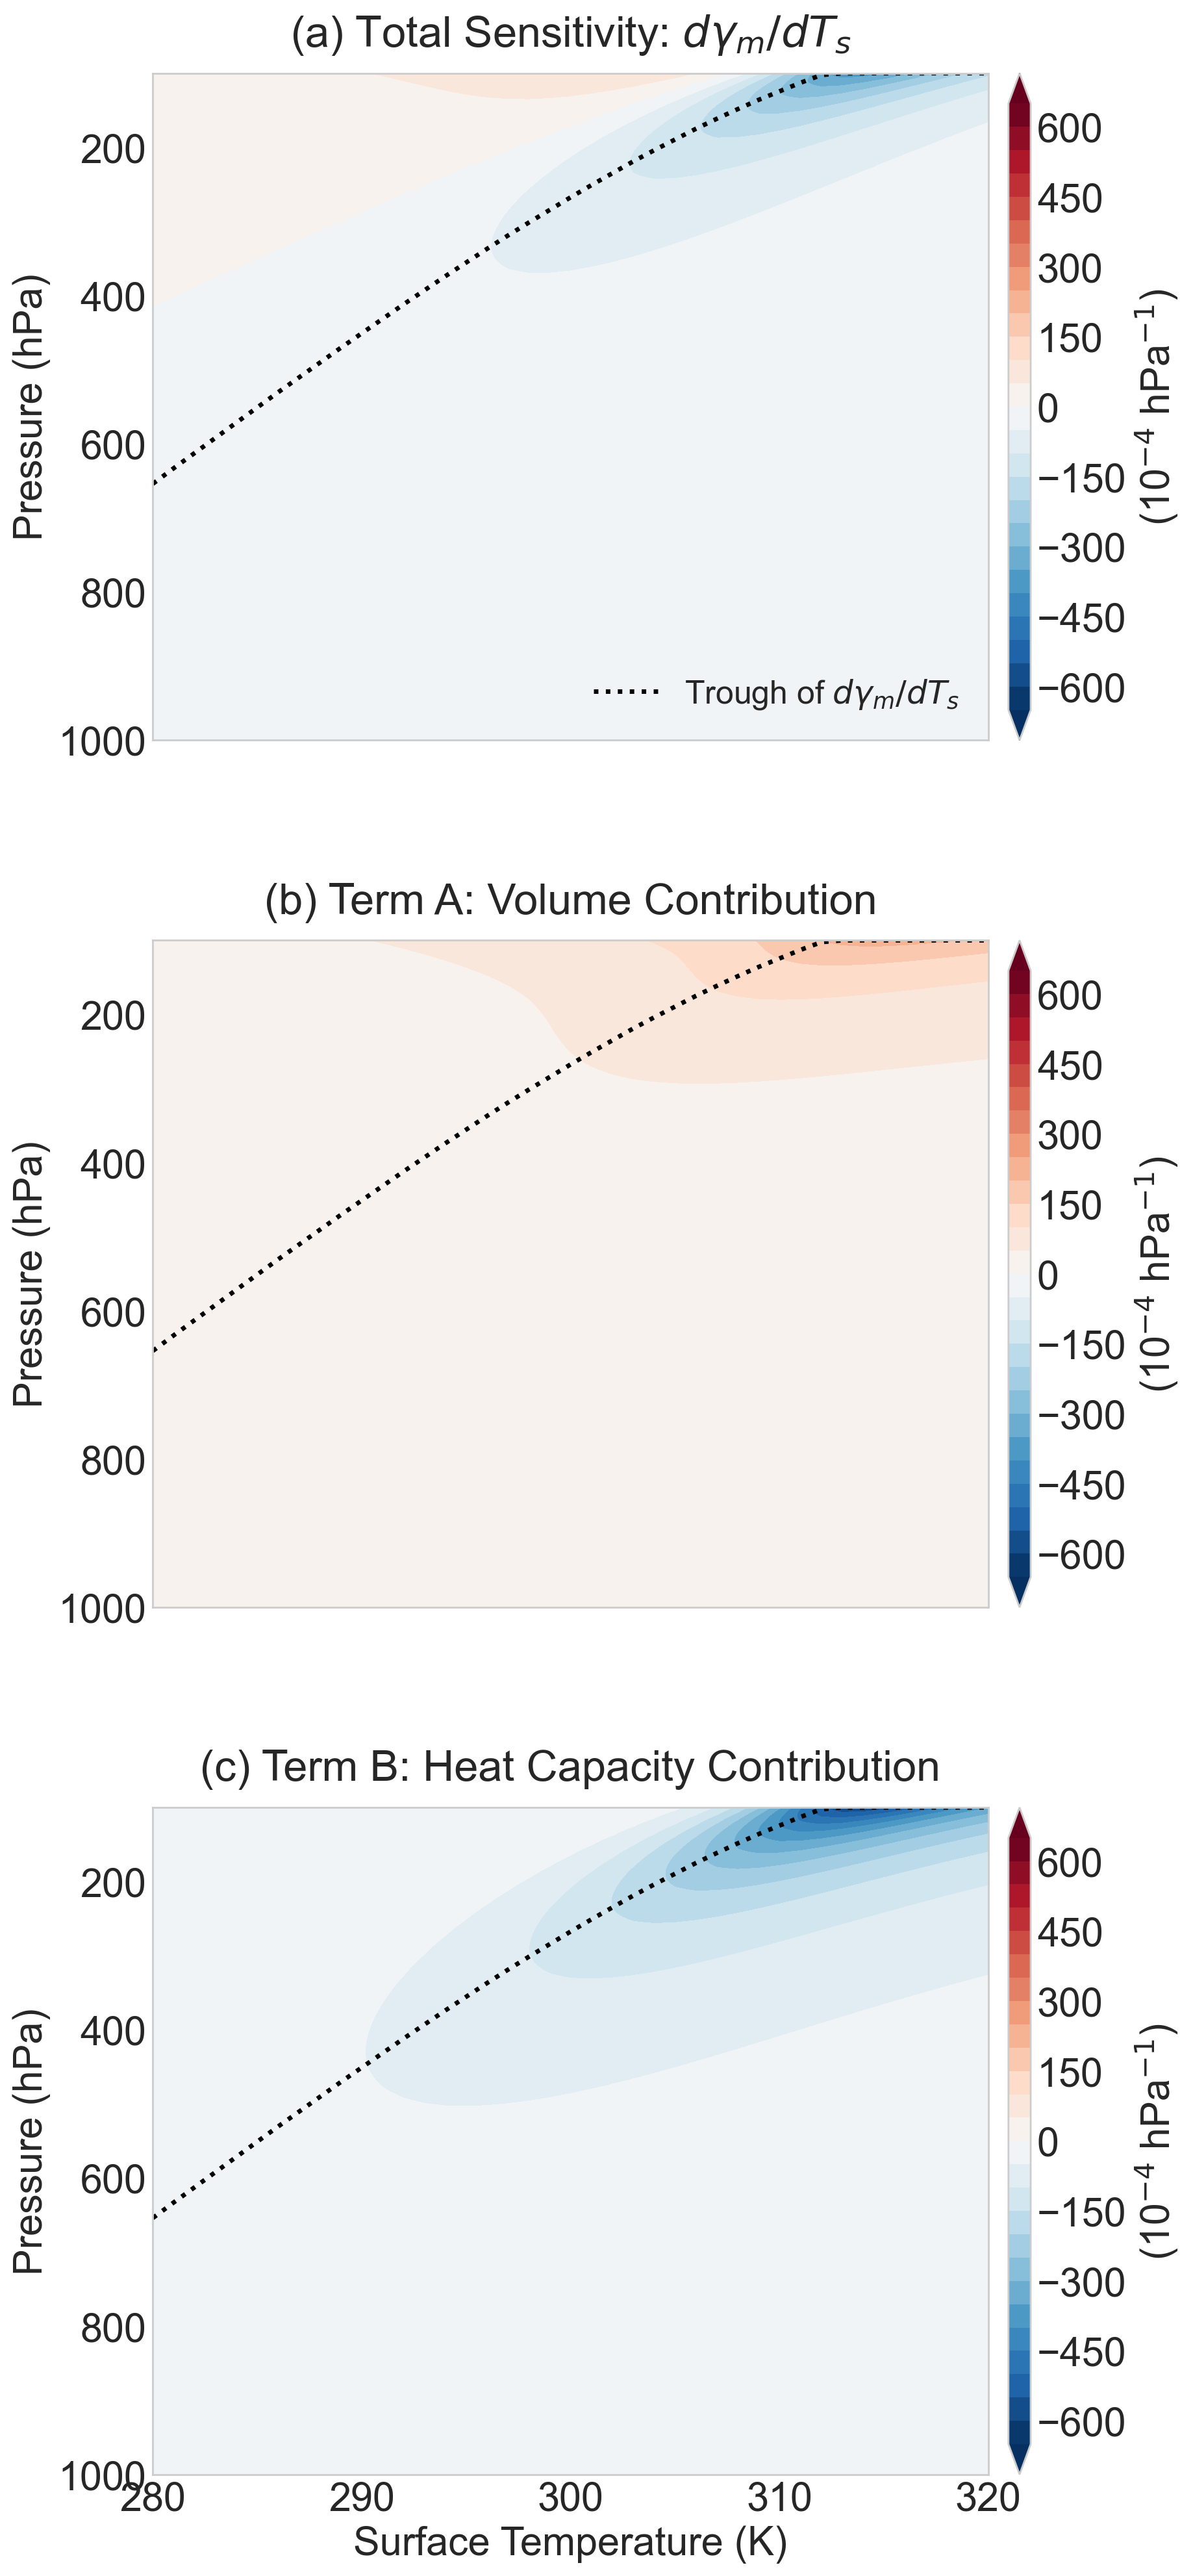

Figure 2 (analytical) saved as fig-2-analytical.png

Script finished.


In [12]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE 2 (Sensitivity Decomposition - Analytical)
#
# This script calculates the moist adiabat sensitivity using the exact analytical
# solution derived from the Volterra integral equation:
#
#   d(gamma_m)/dTs = [d(gamma_m)/dT]_local * exp( integral([d(gamma_m)/dT]_local dp) )
#
# This method removes the need for a finite-difference approximation based on
# a perturbed temperature profile.
#
# The script performs the following actions:
# 1. Defines thermodynamic constants and functions, including helpers for the
#    second-order partial derivatives of saturation specific humidity.
# 2. For each surface temperature, it calculates a single baseline moist adiabat.
# 3. Along this adiabat, it computes the local sensitivity [d(gamma_m)/dT]_local
#    and its components (Term A and Term B).
# 4. It numerically integrates [d(gamma_m)/dT]_local to find the amplification factor.
# 5. It computes the total sensitivity and its components by multiplying the local
#    terms by the amplification factor.
# 6. Creates Figure 2, a three-panel filled contour plot showing the results.
# ==============================================================================

# For sharper inline plots in Jupyter environments
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
from matplotlib.lines import Line2D
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Thermodynamic Functions (including 2nd derivatives) ---

def saturation_vapor_pressure(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denominator, out=np.full_like(p, 1e-9), where=denominator>0)
    return np.maximum(qs, 1e-9)

def dqs_dT(p, T, dT=0.01):
    qs_plus = saturation_specific_humidity(p, T + dT)
    qs_minus = saturation_specific_humidity(p, T - dT)
    return (qs_plus - qs_minus) / (2 * dT)

def dqs_dp(p, T, dp=10.0):
    qs_plus = saturation_specific_humidity(p + dp, T)
    qs_minus = saturation_specific_humidity(p - dp, T)
    return (qs_plus - qs_minus) / (2 * dp)

def d2qs_dT2(p, T, dT=0.01):
    """Numerically calculates d^2(qs)/dT^2 at constant p."""
    qs_plus = saturation_specific_humidity(p, T + dT)
    qs_base = saturation_specific_humidity(p, T)
    qs_minus = saturation_specific_humidity(p, T - dT)
    return (qs_plus - 2 * qs_base + qs_minus) / (dT**2)

def d2qs_dTdp(p, T, dT=0.01, dp=10.0):
    """Numerically calculates d^2(qs)/dTdp."""
    dqs_dT_plus_p = dqs_dT(p + dp, T, dT)
    dqs_dT_minus_p = dqs_dT(p - dp, T, dT)
    return (dqs_dT_plus_p - dqs_dT_minus_p) / (2 * dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    mse = cpd * T + g * z + Lv * qs
    return mse

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)
    T_profile[0], z_profile[0] = T_surf, 0.0
    mse_conserved = calculate_mse(T_profile[0], p_grid[0], 0.0)
    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]
        if np.isnan(T_curr) or p_curr <= 0: break
        Tv_curr = virtual_temperature(T_curr, p_curr)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        def mse_residual(T_guess): return calculate_mse(T_guess, p_next, z_next) - mse_conserved
        try:
            bracket = [150.0, T_curr + 5.0]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1], z_profile[i+1] = sol.root, z_next
            else: break
        except (ValueError, RuntimeError): break
    return T_profile

# --- Main Calculation Block ---
print("--- Starting Main Calculation (Analytical Sensitivity) ---")
start_time = time.time()

# Parameters
T_surf_values = np.arange(280, 320.1, 1.0)
p_surf_pa = 100000.0
p_top_pa = 10000.0
dp_pa = -50.0
p_grid = np.arange(p_surf_pa, p_top_pa + dp_pa, dp_pa)

# Initialize 2D grids for storing results
n_p, n_t = len(p_grid), len(T_surf_values)
total_sensitivity_grid = np.full((n_p, n_t), np.nan)
term_A_total_grid = np.full((n_p, n_t), np.nan)
term_B_total_grid = np.full((n_p, n_t), np.nan)

for i, T_s in enumerate(T_surf_values):
    print(f"Processing Ts = {T_s:.1f} K...")
    T_profile = calculate_profile_with_rootfinder(T_s, p_surf_pa, p_grid)
    
    if not np.isnan(T_profile[-1]):
        # Calculate local thermodynamic quantities along the baseline profile
        alpha_d = Rd * T_profile / p_grid
        c_L = Lv * dqs_dT(p_grid, T_profile)
        alpha_L = Lv * dqs_dp(p_grid, T_profile)
        
        # Calculate terms needed for the local sensitivity d(gamma_m)/dT
        d_alphaL_dT = Lv * d2qs_dTdp(p_grid, T_profile)
        d_cL_dT = Lv * d2qs_dT2(p_grid, T_profile)
        
        # Numerator and Denominator of gamma_m
        N = alpha_d - alpha_L
        D = cpd + c_L
        
        # Derivatives of N and D w.r.t local T
        dN_dT_local = (Rd / p_grid) - d_alphaL_dT
        dD_dT_local = d_cL_dT
        
        # Local sensitivity d(gamma_m)/dT
        d_gamma_m_dT_local = (D * dN_dT_local - N * dD_dT_local) / (D**2)
        
        # Calculate the amplification factor: exp(integral)
        integral_val = cumulative_trapezoid(d_gamma_m_dT_local, x=p_grid, initial=0)
        amplification_factor = np.exp(integral_val)
        
        # Calculate total sensitivity
        total_sensitivity_grid[:, i] = d_gamma_m_dT_local * amplification_factor
        
        # Decompose the total sensitivity
        # Term A (local) = (D*dN_dT_local)/D^2 = dN_dT_local/D
        # Term B (local) = (-N*dD_dT_local)/D^2
        term_A_local = dN_dT_local / D
        term_B_local = (-N * dD_dT_local) / (D**2)
        
        term_A_total_grid[:, i] = term_A_local * amplification_factor
        term_B_total_grid[:, i] = term_B_local * amplification_factor
    else:
        print(f" -> Failed to generate complete profile for Ts = {T_s:.1f} K.")

# --- Find the pressure of the trough for each Ts ---
trough_p_indices = np.nanargmin(total_sensitivity_grid, axis=0)
trough_pressures = p_grid[trough_p_indices] / 100.0
valid_trough = np.isfinite(total_sensitivity_grid[trough_p_indices, np.arange(n_t)])

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Plotting Figure 2 ---
print("--- Generating Figure 2 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize, 'axes.titlesize': base_fontsize + 2,
    'axes.labelsize': base_fontsize, 'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize, 'legend.fontsize': base_fontsize - 4
})

fig, axes = plt.subplots(3, 1, figsize=(10, 24), sharex=True)
p_hpa_grid = p_grid / 100.0
T_grid_K, P_grid_hPa = np.meshgrid(T_surf_values, p_hpa_grid)

# Unify the color scale
scale = 1e6
v_max = np.nanmax([np.abs(total_sensitivity_grid), np.abs(term_A_total_grid), np.abs(term_B_total_grid)]) * scale
step = 50.0
limit = np.ceil(v_max / step) * step
levels = np.arange(-limit, limit + step, step)
if len(levels) < 2: levels = np.arange(-200, 201, 50)

cmap = plt.get_cmap('RdBu_r')
plot_data = [
    {'grid': total_sensitivity_grid * scale, 'title': r'(a) Total Sensitivity: $d\gamma_m / dT_{s}$'},
    {'grid': term_A_total_grid * scale, 'title': '(b) Term A: Volume Contribution'},
    {'grid': term_B_total_grid * scale, 'title': '(c) Term B: Heat Capacity Contribution'}
]

for i, ax in enumerate(axes):
    data = plot_data[i]
    contour = ax.contourf(T_grid_K, P_grid_hPa, data['grid'], levels=levels, cmap=cmap, extend='both')
    ax.set_title(data['title'], pad=15)
    ax.set_ylabel('Pressure (hPa)')
    ax.invert_yaxis()
    ax.set_ylim(1000, 100)
    ax.plot(T_surf_values[valid_trough], trough_pressures[valid_trough], color='black', linewidth=2.5, linestyle=':')
    cbar = fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label('(10$^{-4}$ hPa$^{-1}$)')

legend_elements = [Line2D([0], [0], color='black', lw=2.5, ls=':', label=r'Trough of $d\gamma_m/dT_s$')]
axes[0].legend(handles=legend_elements, loc='lower right')
axes[2].set_xlabel('Surface Temperature (K)')
fig.align_ylabels(axes)
plt.subplots_adjust(hspace=0.3)

fig2_filename = "fig-2-analytical.png"
plt.savefig(fig2_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 2 (analytical) saved as {fig2_filename}")
print("\nScript finished.")
